<div style="display:block">
    <div style="width: 20%; display: inline-block; text-align: left;">
       
    </div>
    <div style="width: 59%; display: inline-block">
        <h1  style="text-align: center">Data Prep,Session Time Calculation, Insights for GreedyGame Data </h1>
        <div style="width: 100%; text-align: center; display: inline-block;"><i>Author:</i> <strong>Aswin.P</strong> </div>
        <div style="width: 100%; text-align: center; display: inline-block;">
            <i>Created: </i>
            <time datetime="2017-04-23" pubdate>April,23,2017</time>
        </div>
    </div>
    <div style="width: 20%; text-align: right; display: inline-block;">
        <div style="width: 50%; display: inline-block; text-align: right;">
    </div>
    </div>
</div>

## Introduction:

The main aim of this  Notebook is to:
1. Calculate the number of sessions (valid and total) of a game and the average session time(only valid) from the given dataset
2. Obtain meaningful insights from user logs 
3. Point out discrepancies in the data and provide suggestive work around

### 1. Loading Packages, Setting Directories,Reading Data:

In [2]:
# Installation part:
#install.packages("lubridate")
#install.packages("reshape2")
#install.packages("gridExtra")
#install.packages("dplyr")
#install.packages("reconstructr")
#install.packages("ggplot2")
#install.packages("grid")
#install.packages("gridExtra")
#install.packages("scales")

# Loading part:
suppressWarnings(suppressMessages(library(lubridate)))
suppressWarnings(suppressMessages(library(dplyr)))
suppressWarnings(suppressMessages(library(reshape2)))
suppressWarnings(suppressMessages(library(reconstructr)))
suppressWarnings(suppressMessages(library(gridExtra)))
suppressWarnings(suppressMessages(library(ggplot2)))
suppressWarnings(suppressMessages(library(grid)))
suppressWarnings(suppressMessages(library(gridExtra)))
suppressWarnings(suppressMessages(library(scales)))
                                  
# setting directories:
setwd("C:/Users/aswin.p/Documents/GreedyGame")
#getwd()

# Reading data:
log_data <- read.table("ggevent.log",sep =':' ,stringsAsFactors = F,strip.white = T)


### 2. Data View and Cleaning of Columns:

The Data has the following columns:
* ai5- unique Device ID
* sdkv- mobile SDK version 
* event- Type of event on the mobile device (GGSTART or GGSTOP)
* game_id- Unique Identifier for a particular game
* timestamp- Time when the request arrived on server (GMT)
* ts- Epoch timestamp value of the device
* debug- null value colum
* random- has values for certain rows only 
* params-  null value column

Among these columns, as of now, we do not use debug,params in our analysis. 
We will delve deeper into the significance of those columns later. 

###### Note:
The Data is also cleaned by removing consecutive GGSTART or GGSTOP values for every ai5,game_id. 
The methodology is explained in the "Discrepancies" section.

In [3]:
# Data cleaning:
# a.Removing the unnecessary columns that got populated while reading the data 
log_data <- log_data[,c('V3','V4','V5','V6','V8','V9','V10','V12','V13')]

# b.Renaming the columns to suitable names:
names(log_data) <- c('ai5','debug','random','sdkv','event','ts','params','timestamp','game_id')

# c.cleaning the values in each columns and replacing the 'null character' values with NA
# text cleaning of the columns, removing header texts and commas and special characters.
log_data$ai5 <- gsub("\\,.*","",log_data$ai5)                                                 
log_data$debug <- gsub("\\,.*","",log_data$debug)                                             
log_data$random <- gsub("\\,.*","",log_data$random) 
log_data$event <- gsub("\\,.*","",log_data$event)
log_data$timestamp <- gsub("\\,.*","",log_data$timestamp)
log_data$ts <- gsub("\\}.*","",log_data$ts)
log_data$sdkv <- gsub("\\}.*","",log_data$sdkv)
log_data$game_id <- gsub("\\}.*","",log_data$game_id)
log_data$debug <- ifelse(log_data$debug =='null',NA,log_data$debug)
log_data$random <- ifelse(log_data$random =='null',NA,log_data$random)
log_data$params <- ifelse(log_data$params=='{}, bottle',NA,gsub(".*{|}.*", "", log_data$params))

##  d.consecutive problem:


# create a unique colum for each ai5,game_id,sdk,event
log_data <- log_data %>% arrange(ai5,game_id,sdkv,timestamp,event)
log_data$uuid <- paste(log_data$ai5,log_data$game_id,log_data$sdkv,log_data$event)

### flag for columns that have repeating GGSTART,GGSTOP values. 
### The first value is taken into the data and rest are flagged till a different event name come up.

event_1 <- log_data$uuid[1]
list_reject <- list()
list_reject[1] <- "no"
for (i in 2:length(log_data$uuid))
{
  event_2 <- log_data$uuid[i]
  if (event_1!=event_2)
  {
    list_reject[i] <- 'no'
    event_1 <- event_2
  }
  else if (grepl('ggstart',event_2))
  {
    list_reject[i-1] <-  "yes"
    list_reject[i] <- "no"
  }
  else if (grepl('ggstop',event_2))
  {
    list_reject[i] <- "yes"
  }
}

list_reject <- unlist(list_reject,recursive=F)
log_data$consec.flag <- list_reject

# removing columns that have "yes" in reject flag column. 
# The final GGSTOP or GGSTART in those consecutive values would be the one that occured:
# a. Latest in case of GGSTART
# b. Earliest in case of GGSTOP.

log_data <- log_data %>% filter(consec.flag=='no')

# e. converting the columns to their appropriate datatypes 
#log_data$timestamp <- strftime(log_data$timestamp,"%Y-%m-%d %H:%M:%OS6", tz = "GMT")
options("digits.sec"=6)
log_data$game_id <- as.integer(log_data$game_id)
log_data$timestamp <- as.POSIXlt(log_data$timestamp,tz="GMT",format="%Y-%m-%d %H:%M:%OS")

### 3. Session time calculation:

Session time is caculated through the following steps:

* Step 1:
    * Finding the time delta between GGSTART and GGSTOP events and create overall session ID
    * This overall session ID cannot differnetiate the >30 "Break time" rule. That is done in Step 4

* Step 2:
    * Removing the events(mostly they will be the events at start of the session) that have null delta time values

* Step 3:
    * Extrapolate the time b/w GGSTART and GGSTOP and vice versa. 
    * For example, we created a new columm "ggstart" that has the time delta b/w previous GGSTOP and current GGSTART,grouped by every ai5,game_id,sdk 
    * The vice versa is done for "ggstop" column.
    * Therefore, "ggstart" column here represents "Break time"
    * "ggstop" column represents "Playing time"
* Step 4:
    * From the inital session ID created, make new Session Id flags when the time between GGSTOP and GGSTART exceeds 30 seconds.
* Step 5:
    * Find and remove the sessions whose total session time is < 1 seconds
* Step 6:
    * Find Valid sessions whose session time is greater than 60 seconds ad create a flag for those sessions
* Step 7:
    * Calculate and display the no.of Sessions(Valid and total) per game 
* Step 8:
    * Find the average session time(for only valid sessions)

In [4]:
# Calculating the number of sessions (valid and total) of the game:

# a. Subsetting for the required columns --ie. removing columns "params","ts","random","debug"
#    
log_data <- log_data[,c('ai5','game_id','sdkv','timestamp','event')]

# b. Using reconstructr package for getting the time delta between ggstart and ggstop
# creating a unique ID for every ai5 and game_id
log_data$uuid <- paste(log_data$ai5,log_data$game_id)
log_data <- sessionise(x = log_data,
                               timestamp = timestamp,
                               user_id = uuid,
                               threshold = 7200)

log_data$uuid <- NULL
log_data$timestamp <- strftime(log_data$timestamp,"%Y-%m-%d %H:%M:%OS6", tz = "GMT")
#as.numeric(difftime(max(log_data$timestamp),min(log_data$timestamp),units = "secs"))

# c. Removing valyues with NA time delta since they are starting of session:
log_data <- log_data %>% filter(!is.na(time_delta))

# d. Decasting the data,for the ggstop and ggstart columns:
#    Column values:
#      1. ggstart - Time between ggstop and ggstart
#      2. ggstop - time bewtween ggstart and ggstop

log_data <- dcast(log_data, ai5+game_id+sdkv+timestamp+session_id ~ event, 
                  value.var = 'time_delta',fun.aggregate = mean)

log_data$ggstart <- ifelse(is.nan(log_data$ggstart),-99999,log_data$ggstart) # replacing the null values to -99999,
                                                                             #so they work with dplyr package


# e. creating session IDs:

##
log_data <- log_data %>% 
                group_by(ai5,game_id,sdkv,timestamp,session_id) %>% 
                mutate(session.flag=ifelse(ggstart>30,
                                            paste(session_id,paste( sample( 0:9, 20, replace=TRUE ), collapse="" ),
                                            sep='/'),
                                           session_id)) 
                                            # wherever the ggstart(here, the column denotes diff b/w stop and stop,
                                          # we create another session id with random 20 digit random number to 
                                          # prevent repetions in large datasets.)

##  filling rest of the session IDs with the new session ID:
old_var <- log_data$session.flag[1]
list_flag <- list()
for (i in 1:length(log_data$session.flag))
{
  new_var <- log_data$session.flag[i]
  if(nchar(old_var)>nchar(new_var))
  {
   old_var <-  ifelse(grepl(new_var,old_var),old_var,new_var)  # when old session id has more length the new ID
  }
  if (nchar(old_var)==nchar(new_var))
  {
    old_var <- ifelse(old_var==new_var,old_var,new_var)        # when both IDs have the same length
  }
  if (nchar(old_var)<nchar(new_var)) 
  {
    old_var <- ifelse(grepl(old_var,new_var),new_var,new_var)  # when the new ID has more length than old ID
  }
  list_flag[i] <- old_var
  
}

list_flag <- unlist(list_flag,recursive=F)
log_data$session_id_final <- list_flag  # combining the final session ID column with log_data set

# f. finding invalid session IDs- ie. sessions that have less than 1 second of total time

log_data$ggstart <- ifelse(log_data$ggstart==-99999,NA,log_data$ggstart) # replacing  -99999 back to null,
log_data$ggstop <- ifelse(is.nan(log_data$ggstop),NA,log_data$ggstop) # replacing nan with NA

log_data <- log_data %>% group_by(session_id_final) %>%  mutate(sesison_time_sum=sum(ggstop,na.rm=TRUE))
# removing rows that have total session time less than 1 

log_data <- log_data %>% 
            filter(sesison_time_sum>=1)

# g. Finding valid sessions:
# creating a flag for valid sessions and taking a unique count of the sessions:
log_data$valid.session.flag <- ifelse(log_data$sesison_time_sum>60,'Valid','Not valid') 


#### 3.a. Number of Sessions Per game(Valid and total):

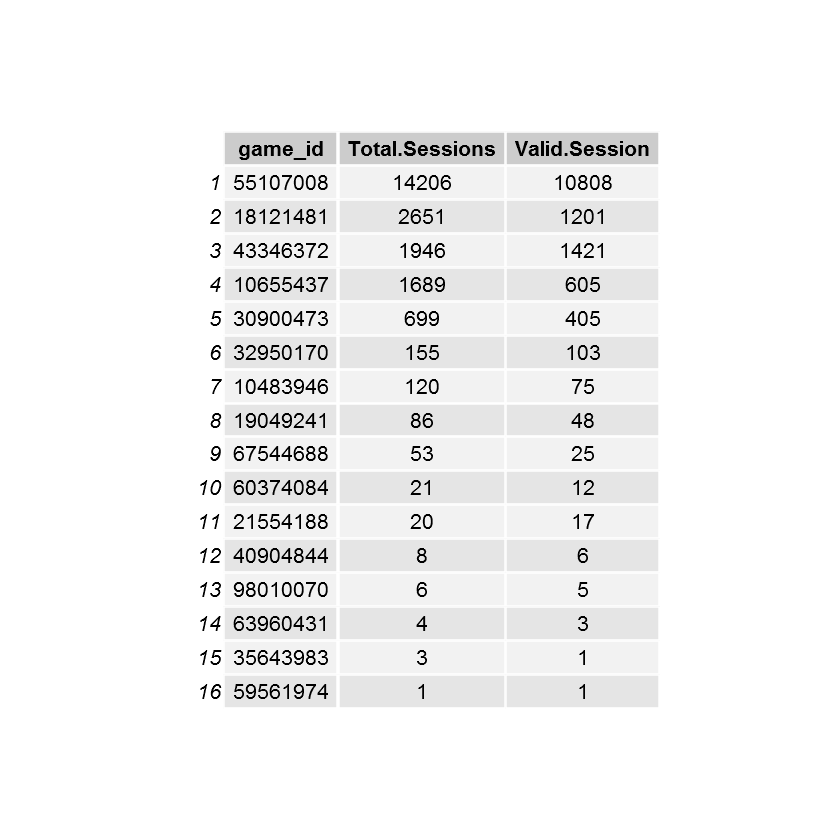

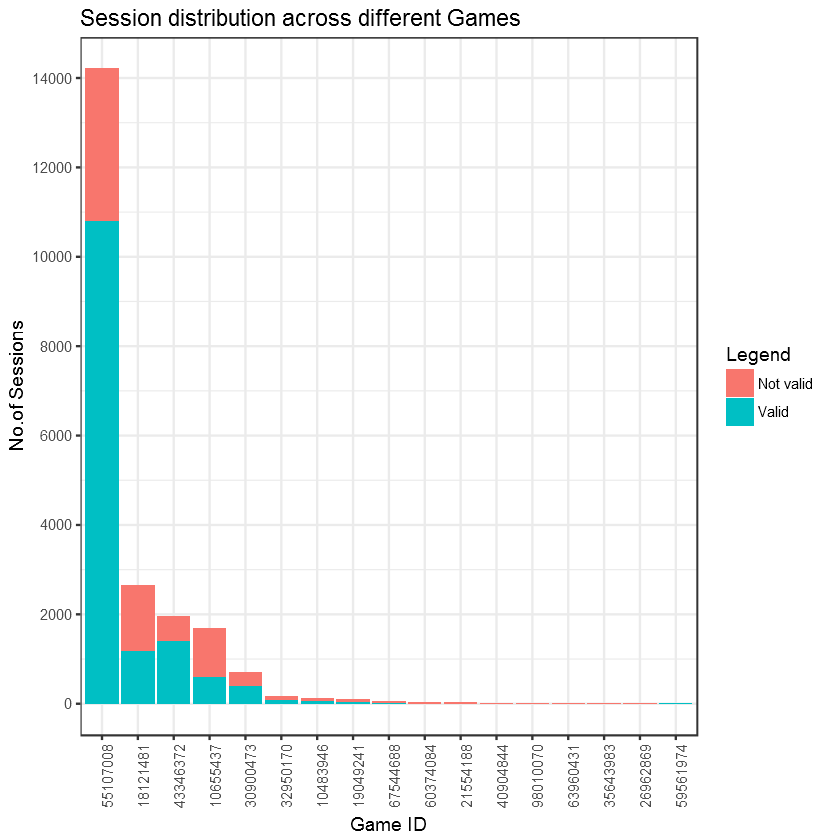

In [5]:
# the number of sessions- valid and total per game:
number_of_session <- log_data %>% group_by(game_id,valid.session.flag) %>% 
                                  summarise(No.of.Sessions= length(unique(session_id_final)))

# valid session
number_of_session_valid <- number_of_session %>% filter(valid.session.flag=='Valid') %>% group_by(game_id) %>%
                           summarise(Valid.Session=sum(No.of.Sessions)) %>%
                            arrange(desc(Valid.Session))

# total session
number_of_session_total <- number_of_session %>% group_by(game_id) %>% summarise(Total.Sessions=sum(No.of.Sessions)) %>%
                            arrange(desc(Total.Sessions))
# displaying first few values only 
number_of_session_display <- merge(number_of_session_total,number_of_session_valid,by='game_id')
number_of_session_display <- number_of_session_display %>% arrange(desc(Total.Sessions))
grid.table(number_of_session_display)

## visualisation as stacked bar chart:
ggplot(data = number_of_session, aes(x = reorder(as.character(game_id),-No.of.Sessions), y = No.of.Sessions, fill = valid.session.flag)) + 
       geom_bar(stat = "identity", position = "stack") + 
      theme_bw() + 
      xlab("Game ID") + 
      ylab("No.of Sessions")  +
      scale_fill_discrete(name="Legend") +
      ggtitle("Session distribution across different Games") +
      theme(axis.text.x = element_text(angle=90)) +
      scale_y_continuous(breaks=scales::pretty_breaks(n=10))

#### 3.b. Average session time(in seconds) per each game for Valid Sessions:

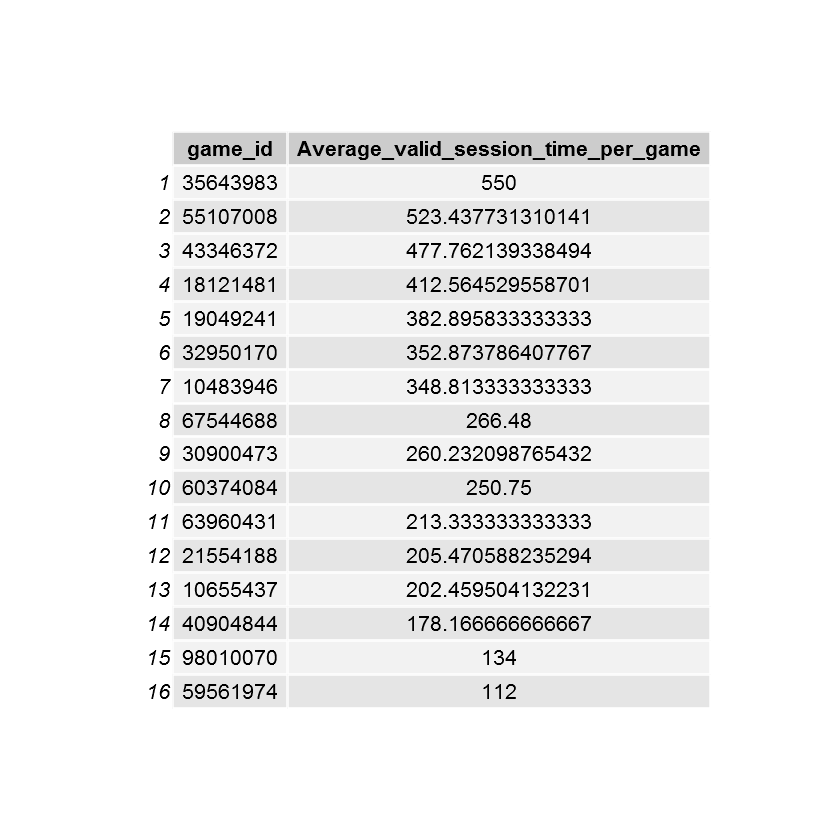

In [7]:
# average session time:(only valid sessions)
average_session_time_pre <- log_data  %>% filter(valid.session.flag=='Valid') %>% 
                                      group_by(game_id,session_id_final) %>%
                                      summarise(total_time=unique(sesison_time_sum)) 

average_session_time <-   average_session_time_pre %>% group_by(game_id) %>% 
                                                      summarise(Average_valid_session_time_per_game= mean(total_time)) %>%
                                                      arrange(desc(Average_valid_session_time_per_game))

# displaying the output
grid.table(average_session_time)

### 4. User Insights:

#### 4.a.User distribution across game:

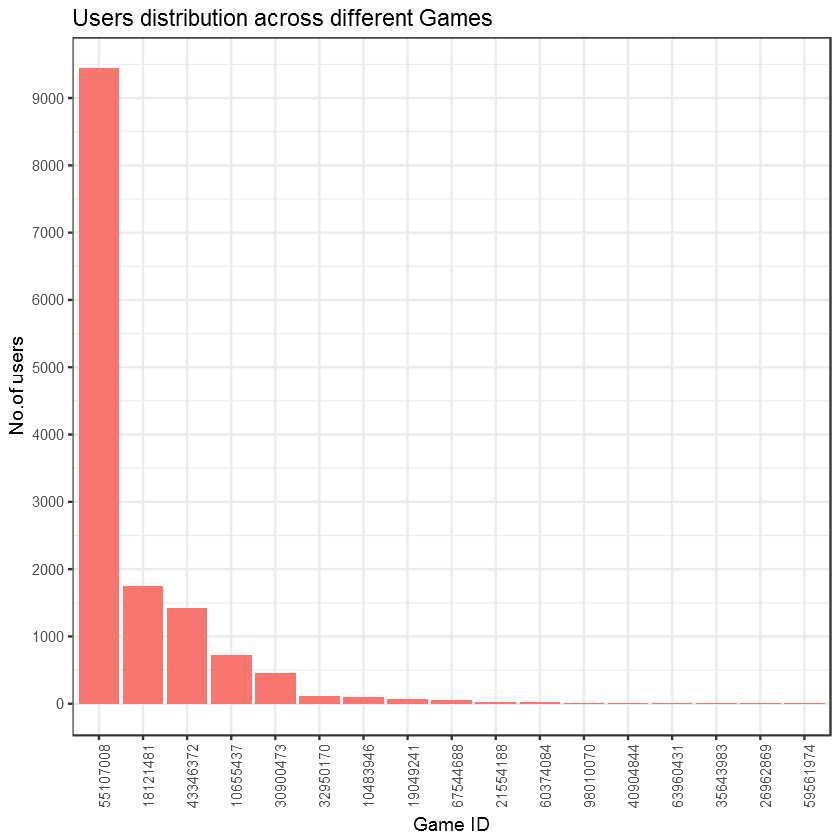

In [8]:
# the number of sessions- valid and total per game:
number_of_users <- log_data %>% group_by(game_id) %>% 
                                  summarise(No.of.users= length(unique(ai5)))

# displaying first few values only 
#grid.table(head(number_of_session))

## visualisation as stacked bar chart:
ggplot(data = number_of_users, aes(x = reorder(as.character(game_id),-No.of.users), y = No.of.users,fill='red')) + 
       geom_bar(stat = "identity") + 
      theme_bw() + 
      xlab("Game ID") + 
      ylab("No.of users")  +
      scale_fill_discrete(name="Legend") +
      ggtitle("Users distribution across different Games") +
      theme(axis.text.x = element_text(angle=90)) +
      scale_y_continuous(breaks=scales::pretty_breaks(n=10)) +
      guides(fill=FALSE) 



<div class="alert alert-success">
<font color=blue>
<b>
Insight-
<br>
<br>
*Around 65% of Users between the given time frame play the game 55107008.*
<br>
*The succeeding 3 games in terms of User counts together make up around 30 % of the total users.* 
<br>
*The rest of the 14 games make up a negligible percentage of the total user count.* 
<br>
<br>
Recommendation-
<br>
<br>
*This shows that Game 55107008 is preferred by the users when compared to other games. From a business standpoint, we can take decisions like investing more resources to improve the Ads in 55107008, thereby targeting a large amount of customers.*
<br>
</b>
</font>
</div>

#### 4.b. Users playing more than one game:

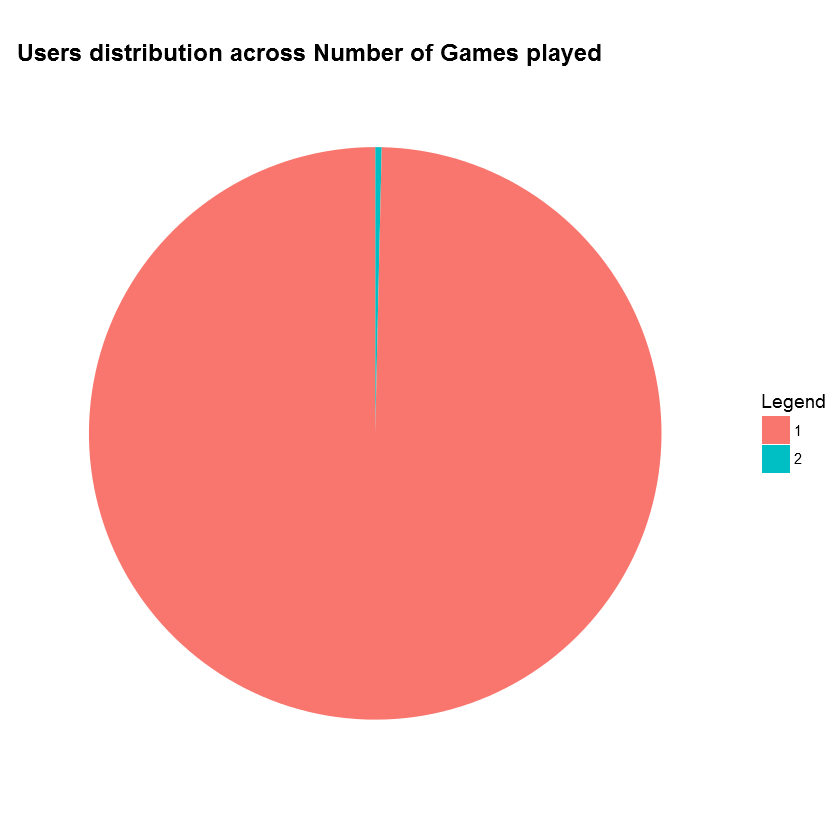

In [9]:
users_game <- log_data %>% group_by(ai5) %>% 
                          summarise(Number_of_games= length(unique(game_id)))

users_game_final <- users_game %>% group_by(Number_of_games) %>% 
                          summarise(counts=length(ai5))

## pie chart visualitation:
blank_theme <- theme_minimal()+
  theme(
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    panel.border = element_blank(),
    panel.grid=element_blank(),
    axis.ticks = element_blank(),
    plot.title=element_text(size=14, face="bold")
  )
ggplot(users_game_final,aes(x="",y=counts,fill=as.factor(Number_of_games)))+
  geom_bar(width=1,stat='identity')+
  coord_polar("y",start=0)+
  blank_theme +
  theme(axis.text.x = element_blank()) +
  scale_fill_discrete(name="Legend") +
  ggtitle("Users distribution across Number of Games played")

<div class="alert alert-success">
<font color=blue>
<b>
Insight-
<br>
<br>
*Very negligible percentage of users play more than one game. This shows that in the given one hour time interval, almost every one played a single game only.* 
<br>
<br>
Recommendation-
<br>
<br>
*This shows users do not switch between games in 1 HR interval. If data with more time period is provided, we can may be verify this hypothesis. And also, more data can give insights into what game preferred by the user in particular time of day.*
</b>
</font>
</div>

#### 4.c.Session time distribution(only Valid session time) of across users:

[1] "Summary of Average Valid Session Time(in secs) per user:"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   61.0   185.0   359.0   508.9   659.0  3445.0 

[1] "InterQuartile Range:"


[1] 474

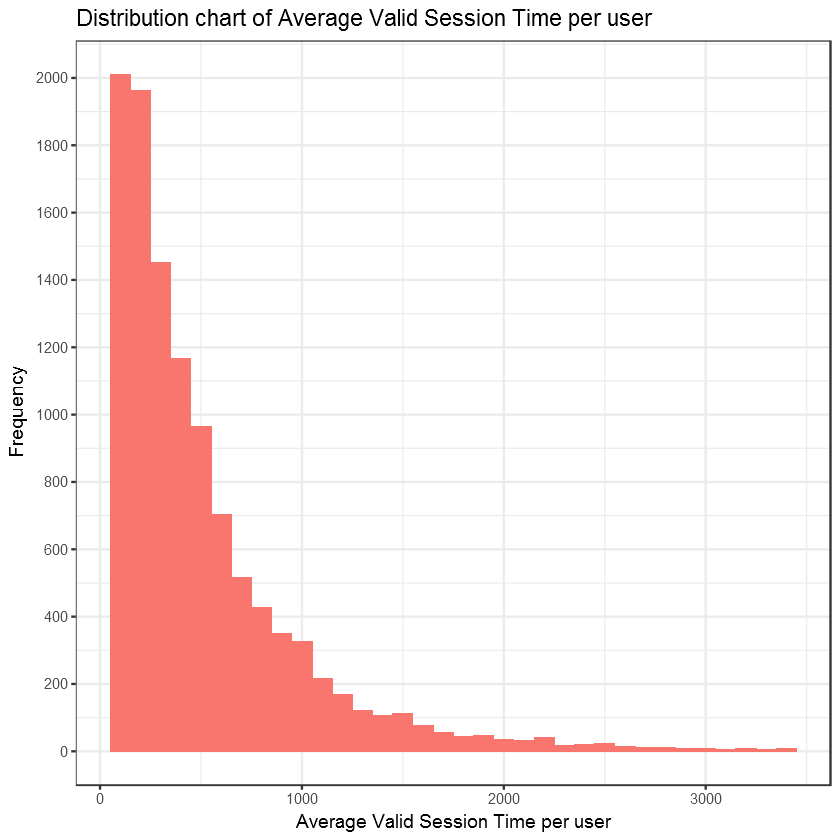

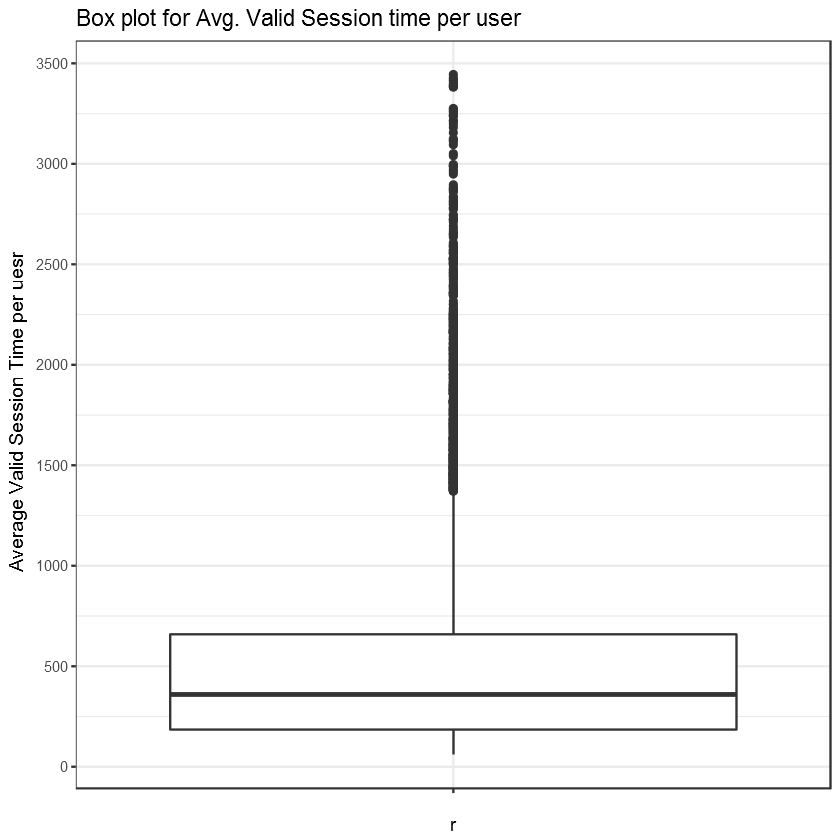

In [10]:
# sesison time distribution across users:
session_time_users <- log_data %>% group_by(ai5,valid.session.flag,session_id_final) %>%  
                                    summarise(session_time=mean(sesison_time_sum))

session_time_users_final <- session_time_users %>% group_by(ai5,valid.session.flag) %>%
                                                    summarise(avg_time_per_session= round(mean(session_time),0))


# filtering only valid session times:
session_time_users_final_valid <- session_time_users_final %>% filter(valid.session.flag=="Valid")

## printing summaries:
print("Summary of Average Valid Session Time(in secs) per user:")
summary(session_time_users_final_valid$avg_time_per_session)
print("InterQuartile Range:")
IQR(session_time_users_final_valid$avg_time_per_session)

## distribution chart 
 ggplot(data = session_time_users_final_valid, aes(x = avg_time_per_session,fill='red'))+    
      geom_histogram(binwidth=100) +
      theme_bw() + 
      xlab("Average Valid Session Time per user") + 
      ylab("Frequency")  +
      ggtitle("Distribution chart of Average Valid Session Time per user") +
      scale_y_continuous(breaks=scales::pretty_breaks(n=10)) +
      guides(fill=FALSE) 

# box plot:
 ggplot(data = session_time_users_final_valid, aes(x = "", y=avg_time_per_session )) +
      geom_boxplot() +
      scale_y_continuous(breaks=scales::pretty_breaks(n=10))+
      theme_bw() + 
      xlab("r") + 
      ylab("Average Valid Session Time per uesr")  +
      ggtitle("Box plot for Avg. Valid Session time per user") 
  


<div class="alert alert-success">
<font color=blue>
<b>
Insight-
<br>
<br>
*Most of the gamers who played in the given time were just looking for a casual game play.*
<br>
*This is supported by the session time statistics:*
<br>
<br>
1. *The average session time is around 508 seconds (or 8.5 minutes)*
<br>
2. *Though the maximum time is around 57 minutes, half of the users play less than 359 secs(or 6 minutes)*
<br>
3. *The 3rd quartile(75th percentile) is 659 secs (or 11 mins).*
<br>
<br>
Recommendation-
<br>
<br>
1. *GreedyGame should place seamless ads such that they capture the attention of gamers within a maximum range of 6-8 minutes*
<br>
2. *Gamers(ai5) can be bucketed into different clusters based on their Session times and targeted Ad placements can be implemented according 
those clusters*
</b>
</font>
</div>

### 5. Discrepancies in Data

##### 5.a Session starting with GGSTOP

<div class="alert alert-success">
<font color=blue>
<b>
1. *Due to Data subset(one hour of data that was provided),there were situations where the for certain users,the data started with GGSTOP.*  
<br>
2. *This was identified and taken care of in "time-delta" calculation part of the code.*
<br>
<br>
3. *The first event of a session will obviously have Null delta time, which helps to identify it easily.*
</b>
</font>
</div>

##### 5.b.Two GGSTART and GGSTOP values coming together:



<div class="alert alert-success">
<font color=blue>
<b>
1. *There were cases where GGSTOP (or GGSTART) occured consecutively.*
<br>
<br>
2. *In this case, it is around 10% of data.*
<br>
<br>
Workaround-
<br>
<br>
a. *If there were more than one GGSTART events were there, the latest one was considered and rest were rejected.*
<br>
b. *If more than one GGSTOP values are found, then the earliest GGSTOP is considered and the following are rejected.*
</b>
</font>
</div>    

##### 5.c.Columns with Null values:

<div class="alert alert-success">
<font color=blue>
<b>
*Two entire columns "params" and "default" had all values as null, for the given data of one hour time period.* 
<br>
</b>
</font>
</div>